In [1]:
%load_ext autoreload
%autoreload 2

# Cluster analysis based on naturalistic stimuli responses

This notebook illustrates how to cluster the models of an ensemble after nonlinear dimensionality reduction on their predicted responses to naturalistic stimuli. This can be done for any cell type. Here we provide a detailed example focusing on clustering based on T4c responses.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [2]:
# @markdown **Check access to GPU**

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch

    try:
        cuda_name = torch.cuda.get_device_name()
        print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
        import warnings

        warnings.warn(
            "You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow)."
        )

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [3]:
if IN_COLAB:
    #@markdown **Install Flyvis**
    %%capture
    !git clone https://github.com/flyvis/flyvis-dev.git
    %cd /content/flyvis-dev
    !pip install -e .

In [4]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams['figure.dpi'] = 200

# Naturalistic stimuli dataset (Sintel)
We load the dataset with our custom augmentations. The dataset contains movie sequences from the publicly available computer-animated movie Sintel rendered to the hexagonal lattice structure of the fly eye. For a more detailed introduction to the dataset class and parameters see the notebook on the optic flow task.

In [5]:
import flyvision
from flyvision.datasets.sintel import AugmentedSintel
import numpy as np

In [18]:
dt = 1 / 100  # can be changed for other temporal resolutions
dataset = AugmentedSintel(tasks=["lum"], dt=dt, temporal_split=True)

In [19]:
# view stimulus parameters
dataset.arg_df

,name,original_index,vertical_split_index,temporal_split_index,frames,flip_ax,n_rot
0,sequence_00_alley_1_split_00,0,0,0,19,0,0
1,sequence_00_alley_1_split_00,0,0,0,19,0,1
2,sequence_00_alley_1_split_00,0,0,0,19,0,2
3,sequence_00_alley_1_split_00,0,0,0,19,0,3
4,sequence_00_alley_1_split_00,0,0,0,19,0,4
...,...,...,...,...,...,...,...
2263,sequence_22_temple_3_split_02,22,68,188,19,1,1
2264,sequence_22_temple_3_split_02,22,68,188,19,1,2
2265,sequence_22_temple_3_split_02,22,68,188,19,1,3
2266,sequence_22_temple_3_split_02,22,68,188,19,1,4


In [20]:
sequence = dataset[0]["lum"]

In [21]:
# one sequence contains 80 frames with 721 hexals each
sequence.shape

torch.Size([159, 1, 721])

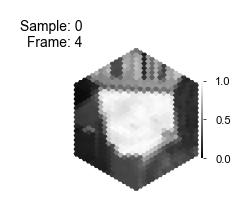

In [22]:
animation = flyvision.animations.HexScatter(sequence[None], vmin=0, vmax=1)
animation.animate_in_notebook(frames=np.arange(5))

# Ensemble responses to a single sequence
We compute the responses of all models in the stored ensemble to the first sequence of the augmented Sintel dataset.

In [23]:
from flyvision import results_dir

In [24]:
# We load the ensemble trained on the optic flow task
ensemble = flyvision.EnsembleView(results_dir / "flow/0000")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-08-27 12:44:07] [network.py:894] Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000.
[2024-08-27 12:44:07] [network.py:894] Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/001.
[2024-08-27 12:44:08] [network.py:894] Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/002.
[2024-08-27 12:44:08] [network.py:894] Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/003.
[2024-08-27 12:44:08] [network.py:894] Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/004.
[2024-08-27 12:44:08] [network.py:894] Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/005.
[2024-08-27 12:44:09] [network.py:894] Initialized network view at /groups/turaga/

`ensemble.simulate` provides an efficient method to return responses of all networks within the ensemble.

In [25]:
responses = np.array(list(ensemble.simulate(sequence[None], dataset.dt, fade_in=True)))

Simulating network:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-08-27 12:44:30] [network.py:239] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-08-27 12:44:30] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:31] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:31] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:31] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:31] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:31] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:32] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:32] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:32] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:32] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:33] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:33] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:44:33] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:4

In [26]:
responses.shape

(50, 1, 159, 45669)

`CentralActivity` is an interface to the response tensor of 45k cells that allows dict- and attribute-style access to the responses of the central cells of the different cell types.

In [27]:
from flyvision.utils.activity_utils import CentralActivity

central_responses = CentralActivity(responses, ensemble[0].connectome, keepref=True)

We visualize the central T4c responses for the whole ensemble

In [28]:
cell_type = "T4c"

In [29]:
n_frames = sequence.shape[0]
time = np.arange(0, n_frames * dataset.dt, dataset.dt)

In [30]:
colors = ensemble.task_error().colors

Text(0.5, 1.0, 'T4c responses across the ensemble')

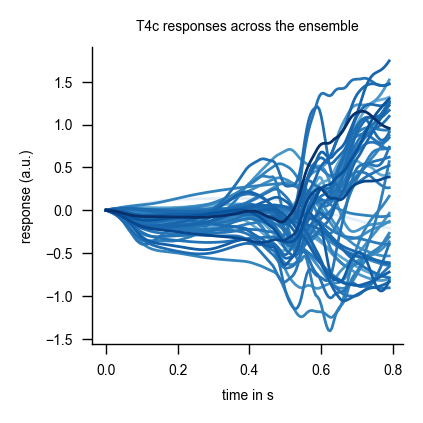

In [31]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
for model_id, response in enumerate(central_responses[cell_type]):
    r = response.squeeze()
    ax.plot(
        time,
        (r - r[0]) / np.abs(r).max(),
        c=colors[model_id],
        zorder=len(ensemble) - model_id,
    )
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("response (a.u.)", fontsize=5)
ax.set_title(f"{cell_type} responses across the ensemble", fontsize=5)

We see that the across models of the ensemble the predictions for T4c vary. Our goal is to understand the underlying structure in those variations.

## Nonlinear dimensionality reduction (UMAP) and Gaussian Mixtures

In [32]:
from matplotlib.pyplot import subplot_mosaic

from flyvision.analysis.clustering import EnsembleEmbedding, get_cluster_to_indices

In [33]:
# specify parameters for umap embedding

embedding_kwargs = {
    "min_dist": 0.105,
    "spread": 9.0,
    "n_neighbors": 5,
    "random_state": 42,
    "n_epochs": 1500,
}

We compute the UMAP embedding of the ensemble based on the T4c responses of the single models to the single sequence for illustration.

In [34]:
central_responses[:].shape

(50, 1, 159, 65)

In [35]:
embedding = EnsembleEmbedding(central_responses)
t4c_embedding = embedding("T4c", embedding_kwargs=embedding_kwargs)

[2024-08-27 12:44:50] [clustering.py:351] reshaped X from (50, 1, 159) to (50, 159)
/home/lappalainenj@hhmi.org/miniconda3/envs/flyvision/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [36]:
task_error = ensemble.task_error()

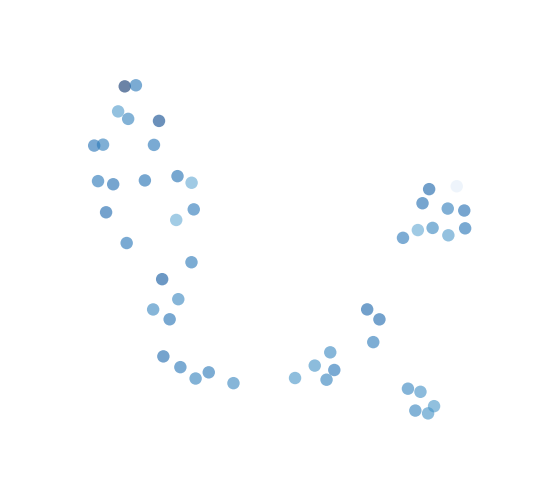

In [37]:
fig, ax = t4c_embedding.plot(colors=task_error.colors)

Each of these scatterpoints in 2d represents a single time series plotted above.

We fit a Gaussian Mixture of 2 to 5 components to this embedding to label the clusters. We select the final number of Gaussian Mixture components that minimize the Bayesian Information Criterion (BIC).

In [38]:
# specifiy parameters for Gaussian Mixture

gm_kwargs = {
    "range_n_clusters": [1, 2, 3, 4, 5],
    "n_init": 100,
    "max_iter": 1000,
    "random_state": 42,
    "tol": 0.001,
}

In [39]:
gm_clustering = t4c_embedding.cluster.gaussian_mixture(**gm_kwargs)

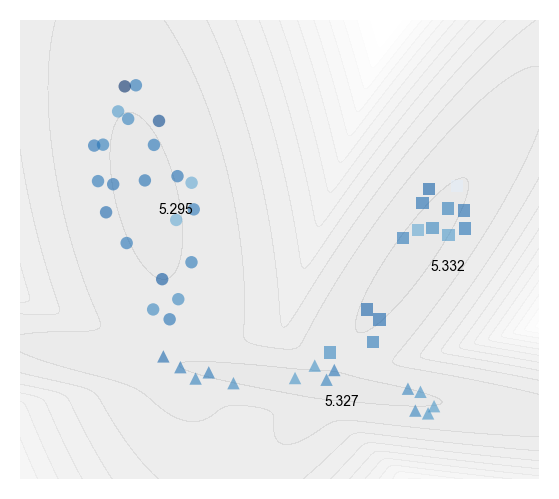

In [40]:
embeddingplot = gm_clustering.plot(
    task_error=task_error.values, colors=task_error.colors
)

We can use the labels to disambiguate the time series data that we plotted above. We expect that these labels aggregate similar time series together and different time series separately.

In [41]:
cluster_to_indices = get_cluster_to_indices(
    embeddingplot.cluster.embedding.mask,
    embeddingplot.cluster.labels,
    ensemble.task_error(),
)

In [42]:
cluster_colors = {}
CMAPS = ["Blues_r", "Reds_r", "Greens_r", "Oranges_r", "Purples_r"]

for cluster_id in cluster_to_indices:
    cluster_colors[cluster_id] = ensemble.task_error(cmap=CMAPS[cluster_id]).colors

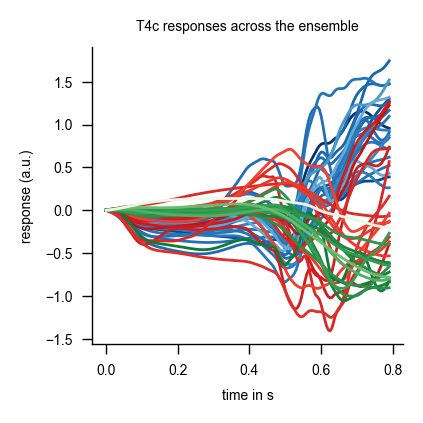

In [43]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
for cluster_id, model_ids in cluster_to_indices.items():
    for model_id, response in zip(
        model_ids, central_responses[cell_type][np.array(model_ids)]
    ):
        r = response.squeeze()
        ax.plot(
            time, (r - r[0]) / np.abs(r).max(), c=cluster_colors[cluster_id][model_id]
        )

ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("response (a.u.)", fontsize=5)
ax.set_title(f"{cell_type} responses across the ensemble", fontsize=5)
ylim = ax.get_ylim()

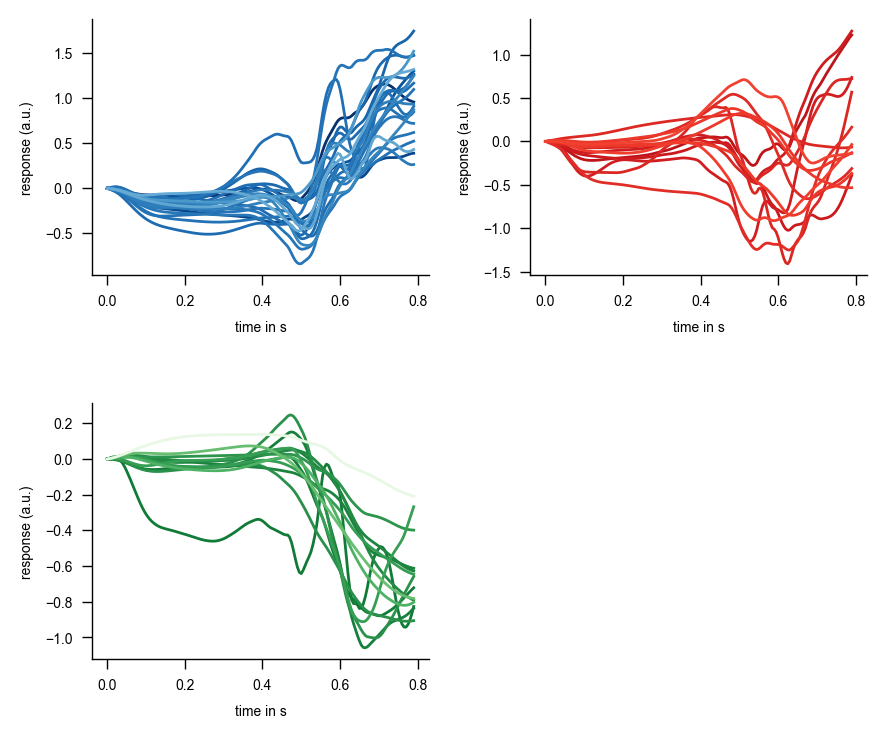

In [44]:
fig, axes, _ = flyvision.plots.plt_utils.get_axis_grid(
    cluster_to_indices, fontsize=5, figsize=[5, 4], wspace=0.3, hspace=0.5
)
for cluster_id, model_ids in cluster_to_indices.items():
    ax = axes[cluster_id]
    for model_id, response in zip(
        model_ids, central_responses[cell_type][np.array(model_ids)]
    ):
        r = response.squeeze()
        ax.plot(
            time, (r - r[0]) / np.abs(r).max(), c=cluster_colors[cluster_id][model_id]
        )
    ax.set_xlabel("time in s", fontsize=5)
    ax.set_ylabel("response (a.u.)", fontsize=5)

The clustering has led us to 5 qualitatively distinct predictions from the ensemble for this cell and sequence. This is a first lead for an underlying structure in these predictions. We will get an even better estimate once we use more sequences for the clustering.

# Clustering based on the ensemble responses to the whole dataset

In [45]:
from flyvision.utils.activity_utils import StimulusResponseIndexer
from flyvision.utils.activity_utils import CellTypeArray

Because this analysis is costly, we randomly select a subset of samples from the dataset of 2268 sequences to illustrate how it scales (one may set 'indices' to None to compute all responses). We can also include only the best x-% of models if we wanted. Skip ahead to the next section to download the precomputed clusterings.

In [46]:
np.random.seed(42)
indices = np.random.choice(np.arange(len(dataset)), replace=False, size=64)


with ensemble.ratio(best=1.0):
    responses = np.stack(
        list(
            ensemble.simulate_from_dataset(
                dataset,
                dt=1 / 100,
                indices=indices,
                batch_size=4,
                central_cell_only=True,
            )
        )
    )

Simulating network:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-08-27 12:45:07] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:11] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:11] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:15] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:15] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:19] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:19] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:23] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:23] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:27] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:27] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:31] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:31] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:35] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:36] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:39] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:40] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:43] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:43] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:47] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:47] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:51] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:51] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:55] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:45:56] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:45:59] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:00] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:03] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:04] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:07] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:08] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:11] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:12] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:15] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:16] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:19] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:20] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:23] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:24] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:27] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:28] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:31] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:32] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:36] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:36] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:40] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:40] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:44] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:44] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:48] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:48] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:52] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:52] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:46:56] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:46:56] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:00] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:00] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:04] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:04] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:08] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:08] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:12] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:12] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:16] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:16] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:20] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:20] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:24] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:24] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:28] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:28] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:32] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:32] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:36] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:36] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:40] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:40] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:44] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:44] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:48] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:48] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:52] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:52] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:47:56] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:47:56] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:48:00] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:00] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:48:04] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:04] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:48:08] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:08] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:48:12] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:13] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:48:16] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:17] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:48:21] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:21] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

[2024-08-27 12:48:25] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:25] [network.py:729] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

(<Figure size 1400x800 with 1 Axes>,
 <Axes: title={'center': 'T4c stimulus response'}, xlabel='time (s)', ylabel='activity (a.u.)'>)

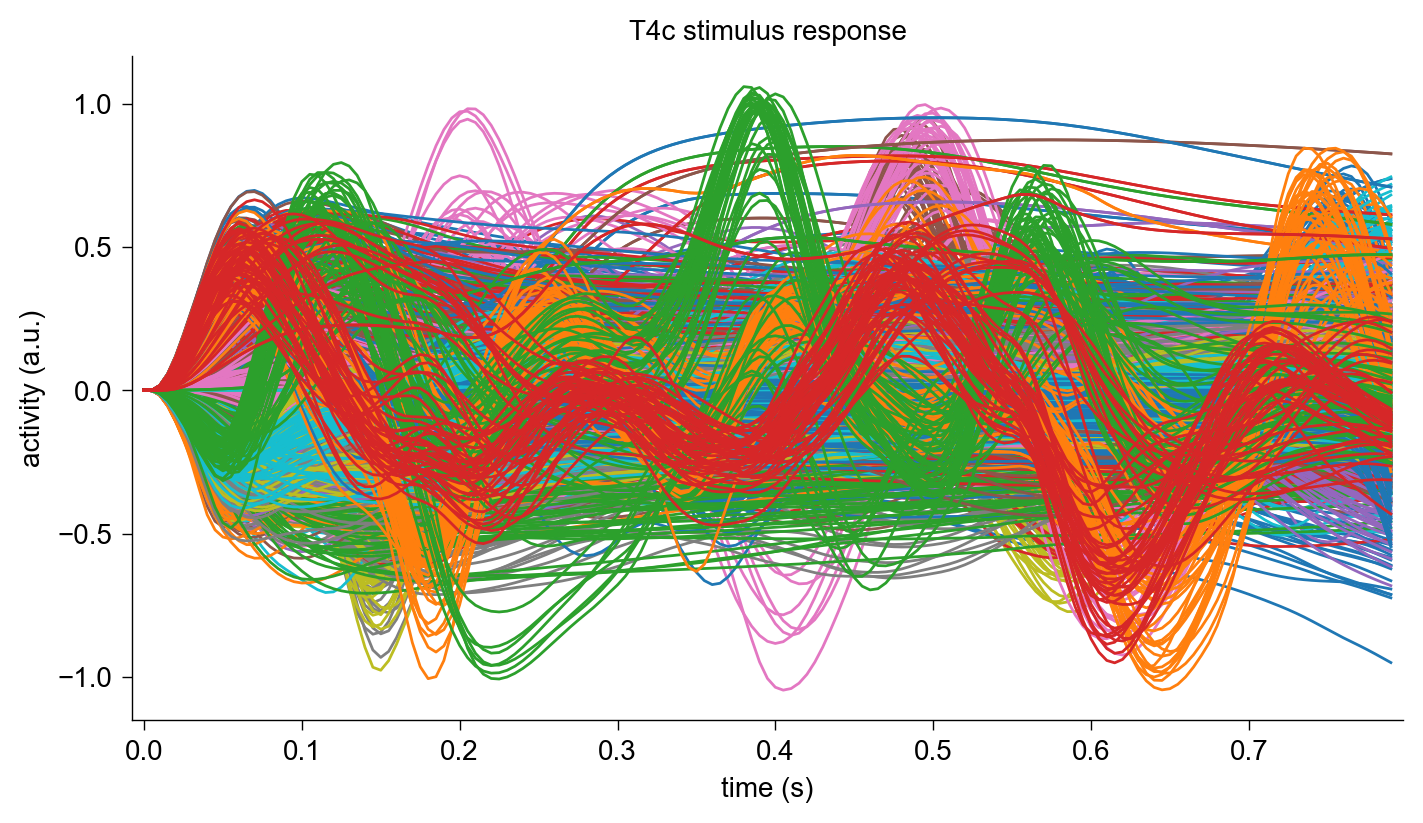

In [47]:
arg_df = dataset.arg_df.loc[indices].reset_index(drop=True)
sri = StimulusResponseIndexer(
    arg_df,
    CellTypeArray(responses, ensemble[0].connectome),
    dt=dataset.dt,
    t_pre=0,
    temporal_dim=2,
    stim_sample_dim=1,
)

centered = sri - sri.responses.array[:, :, [0]]
centered /= sri.abs().max(dims=(1, 2), keepdims=True)

centered.plot_traces("T4c", plot_kwargs=dict(legend=[]))

When we plot the centered T4c responses across all models and stimuli we see again lots of structure. The amount of data would now make it difficult to disambiguate them all at this scale manually. It would also be easier to interpret differences in responses to simple stimuli rather than to naturalistic stimuli.

That's why we again first compute a non-linear dimensionality reduction of these traces to 2d and then we cluster to understand the structure in the dataset. The dim. reduction just pretends that traces from individual movie sequences are a single long trace that needs to be embedded. Afterwards we interpret differences in these clusters in responses to simple stimuli.

In [48]:
central_responses = CentralActivity(responses, ensemble[0].connectome, keepref=True)

In [49]:
embedding = EnsembleEmbedding(central_responses)
t4c_embedding = embedding("T4c", embedding_kwargs=embedding_kwargs)

[2024-08-27 12:48:38] [clustering.py:351] reshaped X from (50, 64, 159) to (50, 10176)
/home/lappalainenj@hhmi.org/miniconda3/envs/flyvision/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [50]:
gm_kwargs = {'range_n_clusters': [2, 3, 3, 4, 5],
 'n_init': 100,
 'max_iter': 1000,
 'random_state': 42,
 'tol': 0.001}

In [51]:
with ensemble.ratio(best=1.0):
    task_error = ensemble.task_error()

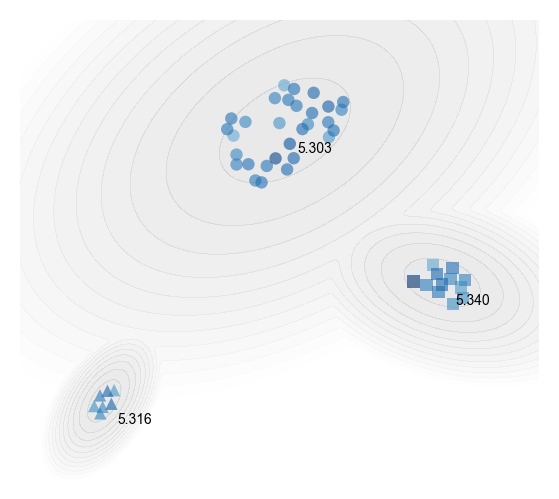

In [52]:
embeddingplot = t4c_embedding.cluster.gaussian_mixture(**gm_kwargs).plot(
    task_error=task_error.values, colors=task_error.colors
)

This clustering looks already very close to the result in the paper! Note though that this is still based on a small subset of the Sintel dataset.

# Using the clustering to discover tuning predictions in responses to simple stimuli

We expect that the clustering based on naturalistic stimuli will also disambiguate the different tuning predictions from different models for simple stimuli.

In [53]:
cluster_to_indices = get_cluster_to_indices(
    embeddingplot.cluster.embedding.mask,
    embeddingplot.cluster.labels,
    ensemble.task_error(),
)

In [54]:
# define different colormaps for clusters
cluster_colors = {}
CMAPS = ["Blues_r", "Reds_r", "Greens_r", "Oranges_r", "Purples_r"]

for cluster_id in cluster_to_indices:
    cluster_colors[cluster_id] = ensemble.task_error(cmap=CMAPS[cluster_id]).colors

## Clustered voltage responses to moving edges

In [55]:
from flyvision.datasets.moving_bar import MovingEdge

In [56]:
mer_dataset = MovingEdge(
    offsets=[-10, 11],  # offset of bar from center in 1 * radians(2.25) led size
    intensities=[0, 1],  # intensity of bar
    speeds=[19],  # speed of bar in 1 * radians(5.8) / s
    height=80,  # height of moving bar in 1 * radians(2.25) led size
    post_pad_mode="continue",  # for post-stimulus period, continue with the last frame of the stimulus
    t_pre=1.0,  # duration of pre-stimulus period
    t_post=1.0,  # duration of post-stimulus period
    dt=1 / 100,  # temporal resolution of rendered video
    angles=list(np.arange(0, 360, 30)),  # motion direction (orthogonal to edge)
)

In [57]:
central_cells_index = ensemble[0].connectome.central_cells_index[:]
with ensemble.ratio(best=1.0):  # take only top 20% (10 in this case) of models
    mer = np.stack(
        list(
            ensemble.simulate_from_dataset(
                mer_dataset,
                dt=mer_dataset.dt,
                batch_size=4,
                central_cell_only=True,
            )
        )
    )

Simulating network:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-08-27 12:48:47] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:48:52] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:52] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:48:57] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:48:57] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:01] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:01] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:06] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:06] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:11] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:11] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:15] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:15] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:20] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:20] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:25] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:25] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:29] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:30] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:34] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:34] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:39] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:39] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:44] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:44] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:48] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:48] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:53] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:53] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:49:58] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:49:58] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:02] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:03] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:07] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:07] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:12] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:12] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:17] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:17] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:22] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:22] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:26] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:27] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:31] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:31] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:36] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:36] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:41] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:41] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:45] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:45] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:50] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:50] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:50:55] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:50:55] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:00] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:00] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:05] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:05] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:09] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:09] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:14] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:14] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:19] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:19] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:23] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:24] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:28] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:28] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:33] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:33] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:37] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:37] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:42] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:42] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:47] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:47] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:52] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:52] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:51:56] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:51:57] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:01] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:01] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:06] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:06] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:11] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:11] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:15] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:15] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:20] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:20] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:25] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:25] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:30] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:30] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:34] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:35] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-08-27 12:52:39] [chkpt_utils.py:68] Recovered network state.
[2024-08-27 12:52:39] [network.py:729] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

In [58]:
responses_array = CellTypeArray(
    mer,
    cell_types=ensemble[0].connectome.unique_cell_types[:].astype(str),
)

[autoreload of flyvision.network failed: Traceback (most recent call last):
  File "/home/lappalainenj@hhmi.org/miniconda3/envs/flyvision/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/lappalainenj@hhmi.org/miniconda3/envs/flyvision/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/lappalainenj@hhmi.org/miniconda3/envs/flyvision/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/flyvision/network.py", line 856, in <module>
    class NetworkView(ConnectomeView):
  File "/groups/turaga/home/lappalainenj

In [59]:
from flyvision.analysis.moving_bar_responses import MovingEdgeResponseView

In [60]:
merv = MovingEdgeResponseView(
    arg_df=mer_dataset.arg_df,
    responses=responses_array,
    config=mer_dataset.config,
    stim_sample_dim=1,
    temporal_dim=2,
)

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/flyvision/utils/activity_utils.py:497: RuntimeWarning: invalid value encountered in true_divide
  return self.view(responses=self[:] / other[:])


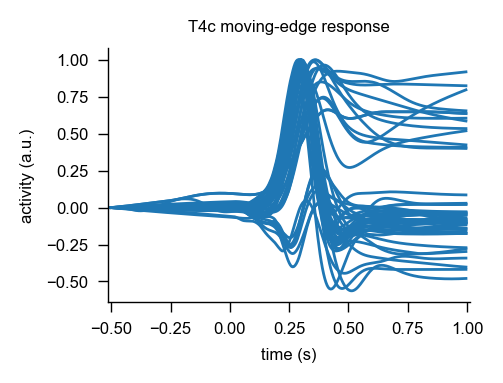

In [61]:
centered = (
    merv.between_seconds(-0.5, 1.0)
    - merv.between_seconds(-0.5, 1.0).responses.array[:, :, [0]]
)
centered /= centered.abs().max(dims=(1, 2), keepdims=True)
centered.plot_traces(
    cell_type="T4c",
    angle=90,
    intensity=1,
    plot_kwargs=dict(figsize=(2.4, 1.8), fontsize=6),
)
plt.show()

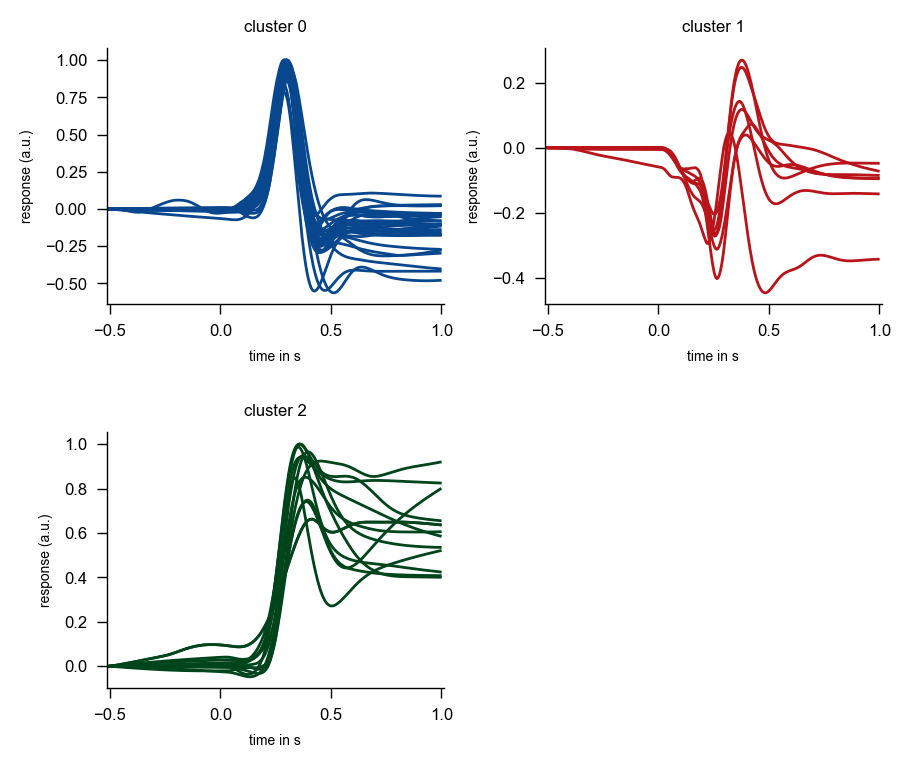

In [62]:
fig, axes, _ = flyvision.plots.plt_utils.get_axis_grid(
    cluster_to_indices, fontsize=5, figsize=[5, 4], wspace=0.3, hspace=0.5
)
for cluster_id, model_ids in cluster_to_indices.items():
    ax = axes[cluster_id]
    centered[model_ids, :, :].plot_traces(
        cell_type="T4c",
        angle=90,
        intensity=1,
        plot_kwargs=dict(
            figsize=(2.4, 1.8),
            fontsize=6,
            fig=fig,
            ax=ax,
            title=f"cluster {cluster_id}",
            color=cluster_colors[cluster_id][model_ids]
        ),
    )
    ax.set_xlabel("time in s", fontsize=5)
    ax.set_ylabel("response (a.u.)", fontsize=5)

## Clustered peak voltage responses to moving edges

(<Figure size 200x200 with 1 Axes>, <PolarAxes: >)

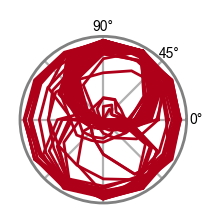

In [63]:
merv.plot_angular_tuning(cell_type="T4c", intensity=1)

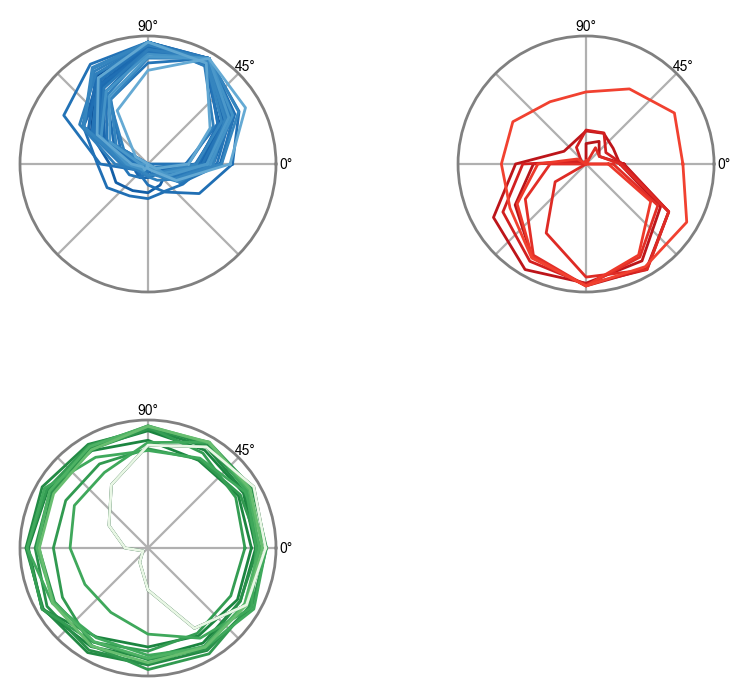

In [64]:
fig, axes, _ = flyvision.plots.plt_utils.get_axis_grid(
    cluster_to_indices,
    fontsize=5,
    figsize=[5, 4],
    wspace=0.3,
    hspace=0.5,
    projection="polar",
)
for cluster_id, model_ids in cluster_to_indices.items():
    ax = axes[cluster_id]
    merv[model_ids, :, :].plot_angular_tuning(
        cell_type="T4c", intensity=1, colors=cluster_colors[cluster_id][model_ids],
        fig=fig, ax=ax
    )

As we can see here, the models quite nicely predict clustered neural responses. We discovered all of these clusters simply by using UMAP and Gaussian Mixtures.

# Load precomputed umap and clustering

Due to the computational requirement of recording and embedding all responses and for consistency we also show how to use the precomputed embeddings and clusterings from the paper.

In [65]:
cell_type = "T4c"
clustering = ensemble.clustering(cell_type)

In [66]:
task_error = ensemble.task_error()

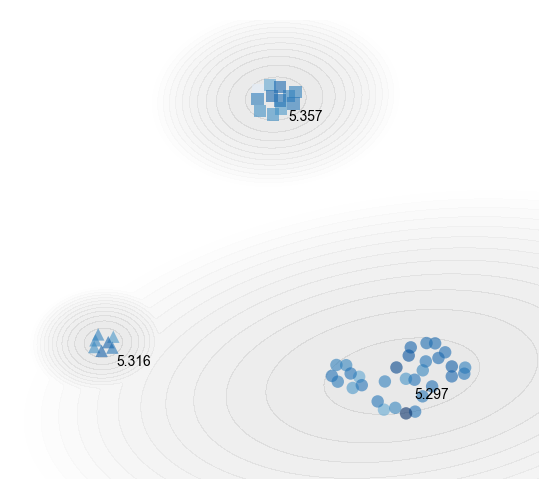

In [67]:
embeddingplot = clustering.plot(task_error=task_error.values,
                                colors=task_error.colors)

With this embedding and clustering one can proceed in the same way as above to plot the tunings.